## OpenMC Mini Workshop at ASEMOT

![OpenMC](img/openmc_logo.png)


**Place**: IIT Bombay

**Time**: Dec 15, 2018 from 1:30 to 3:30 pm

**Facilitators**: Jeremy Roberts and Richard Reed


## The Plan

| Topic               | Duration |
|---------------------|----------|
| Ensure/Debug Remote Access       | 15 min   |
| Overview of OpenMC (key features) | 15 min   |
| A basic pin cell (materials, geometries, settings, and statepoints)    | 30 min   |
| A basic assembly (universes, lattices, and tallies)   | 45 min   |


## Remote Access

Download `asemot.pem` from `https://github.com/corps-g/asemot_openmc`.

In `bash`, navigate to where you downloaded `asemot.pem` and enter

```
ssh -i "asemot.pem" ubuntu@ec2-54-197-16-236.compute-1.amazonaws.com
```

Everyone has the same username `ubuntu` but each registrant has a folder named based on email address.  If your email is

```
jeremy@host.com
```

then your folder name is `jeremy`.  Type `ls` to see all folders.  Use `cd` to enter yours, which contains the two Python files we'll use as examples.



## Caveats and Acknowledgements

I am *not* an OpenMC developer, nor am I an *expert* user!

Much of the material included draws directly from a workshop provided by Paul Romano to the Canadian Nuclear Laboratories and the various examples provided by the OpenMC documentation.

## The Monte Carlo Method and the Life of a Neutron

![Particle Life](img/particle_life.png)


### Tallying Along The Way

Often, analysis requires some quantity $X = \int d\mathbf{r} \int d\mathbf{\Omega} \int dE \;
    f(\mathbf{r},\mathbf{\Omega},E) \psi (\mathbf{r},\mathbf{\Omega},E)$.
    
During simulation, estimate $\hat{X} = \frac{1}{N} \sum\limits_{i \in T} w_i \ell_i f_i$

With several histories and $\hat{X}_1, \hat{X}_2, \ldots$, compute

$$
 \bar{X} = \frac{1}{N} {\sum\limits_{i=1}^N \hat{X}_i} \qquad \text{and} \qquad
    s^2_X = \frac{1}{N-1} \left ( \frac{1}{N} {\sum\limits_{i=1}^N \hat{X}_i^2} -
    \bar{X}^2 \right )
$$

## Monte Carlo and Criticality Calculations

![Eigenvalue Algorithm](img/k_algorithm.png)

## Quick Overview of OpenMC 

### History and Status

  - Development started in 2011 because 
     1. parallel scaling of existing codes was not great
     2. export control made research continuity difficult
  - DOE/NNSA approved open release in 2012
  - Formally funded as of 2016
  - 14+ active developers with contributions from at least 61 individuals
  - Roughly 100k lines of C++, Fortran, and Python
  - OpenMC is still considered to be in *beta*!!
    

### Where Do I Get Help? 

User's Group: [openmc-users@googlegroups.com](openmc-users@googlegroups.com) 

Developer's Group: [openmc-dev@googlegroups.com](openmc-dev@googlegroups.com)

Documentation: [http://openmc.readthedocs.org/en/latest/](http://openmc.readthedocs.org/en/latest/)

### OpenMC Inputs

Execution of OpenMC requires three XML files:

  - `settings.xml`  
  - `materials.xml` 
  - `geometry.xml`
  
with optional features enabled by other files:

  - `tallies.xml`
  - `plots.xml`


### Python API

XML is good, but scripted inputs are better:

  - All XML files automatically generated via Python scripts
  - Rich interface to output data (tallies, etc.)
  - Developmental interface to C API for in-memory, coupled-physics calculations

### Scalable Parallelism

![Parallel Performance](img/parallel_performance.png)

(courtesy P. Romano)

### Handling Temperature Dependence

Because $\Sigma$ depends on $T$, and $T$ varies with $\mathbf{r}$, need 100's of GB's of data using a *brute force* approach.  

**Alternatives**: polynomial fits (Yesilyurt and Martin), target motion sampling (Viitanen and Leppanen), and the **windowed-multipole** (WMP) approach (Hwang; revisited by Forget and Josey in OpenMC), based on the following:

$$
\begin{align*}
      \sigma(u,0) &= \frac{1}{u^2} \sum\limits_j \Re \left [ \frac{r_j}{p_j - u}
        \right ] \\ \sigma(u,T) &= \frac{1}{2u^2\sqrt{\xi}} \sum\limits_j \Re
      \left [ ir_j \sqrt{\pi} W(z_j^0) - \frac{r_j}{\pi} C\left (
        \frac{p_j}{\sqrt{\xi}}, \frac{u}{2\sqrt{\xi}} \right ) \right ]
    \end{align*}
$$

Now, (relatively) little data required, and the problem becomes FLOP dominated (good for large, parallel machines with little memory!  (See details in [Josey et al., J. Comp. Phys.  **307** (2016)](https://dspace.mit.edu/openaccess-disseminate/1721.1/114236))

**Example**: Use WMP data to show impact of Doppler broadening on the absorption cross section of U-238 at 6.67 eV.

Data paths should be set up on the remote server.  

For folks with laptops, show the cross_sections.xml file and how to append WMP data.

Note, WMP is not synced by default, nor does it handle thermal scattering.  Hence, stick with 294 K for the rest of the workshop.

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
path_u238_h5 = '/home/robertsj/Research/openmc/scripts/nndc_hdf5/U238.h5'
path_u238_mp = '/home/robertsj/Research/openmc/scripts/nndc_hdf5/wmp/092238.h5'
u238_h5 = openmc.data.IncidentNeutron.from_hdf5(path_u238_h5)
u238_mp = openmc.data.WindowedMultipole.from_hdf5(path_u238_mp)

/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


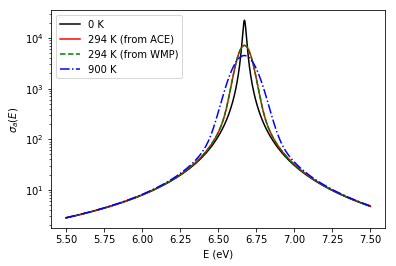

In [2]:
E = np.linspace(5.5, 7.5, 1000)
plt.semilogy(E, u238_mp(E, 0)[1], 'k') # the "1" indexes sigma_a
plt.semilogy(E, u238_h5[102].xs['294K'](E), 'r') # mt=102 is the ENDF mt for sigma_a
plt.semilogy(E, u238_mp(E, 294)[1], 'g--')
plt.semilogy(E, u238_mp(E, 900)[1], 'b-.')
plt.legend(['0 K', '294 K (from ACE)', '294 K (from WMP)', '900 K'])
plt.xlabel('E (eV)')
plt.ylabel('$\sigma_a(E)$')
plt.show()

## Diving In: A Single Pin Cell

**Example**: compute $k_{\infty}$ for this fuel pin:

![Fuel Pin](img/fuel_pin.png)

where the densities for fuel, cladding, and water are 10 g/cm$^3$, 6.6 g/cm$^3$, and 1 g/cm$^3$, respectively. 

### Defining `materials.xml`

First, import `openmc`:

In [3]:
import openmc

Then, define a variable to represent the fuel material:

In [6]:
uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
uo2

/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/openmc-0.10.0-py3.6-linux-x86_64.egg/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	10.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.04         [ao]
	U238           =	0.96         [ao]
	O16            =	2.0          [ao]

In [7]:
uo2 

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	10.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.04         [ao]
	U238           =	0.96         [ao]
	O16            =	2.0          [ao]

Now, do the same for Zr and water:

In [8]:
zirconium = openmc.Material(2, "zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
zirconium # note automated elemental composition

Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	None
	Density        =	6.6 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]

In [9]:
h2o = openmc.Material(3, "h2o")
h2o.add_nuclide('H1', 2.0)
h2o.add_nuclide('O16', 1.0)
h2o.set_density('g/cm3', 1.0)
h2o.add_s_alpha_beta('c_H_in_H2O')  

Now, add these materials to a material library and export the required XML file:

In [10]:
materials = openmc.Materials()
materials += [uo2, zirconium, h2o]
materials.export_to_xml()

In [11]:
!cat materials.xml # this calls "cat materials.xml" in bash

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.04" name="U235" />
    <nuclide ao="0.96" name="U238" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="2" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="3" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="1.0" name="O16" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


### Defining `geometry.xml`

OpenMC uses a combinatorial geometry similar to MCNP and Serpent.  

Start by defining the surfaces needed to represent the fuel pin.  First, the four sides of the box:

In [13]:
pitch = 1.26 # all dimensions in cm
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

Now, define the two cylinders:

In [14]:
fuel_outer = openmc.ZCylinder(R=0.41)
clad_outer = openmc.ZCylinder(R=0.48)

Now, define *cells* comprised of a region enclosed by surfaces and materials. For example, the fuel region is defined by everything "inside of" the `fuel_outer` surface and is filled with `uo2`:

In [15]:
fuel = openmc.Cell(1, 'fuel')
fuel.region = -fuel_outer # the "-" indicates "inside of"
fuel.fill = uo2

/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/openmc-0.10.0-py3.6-linux-x86_64.egg/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)


Similarly, cells for the cladding and coolant can be defined as follows:

In [16]:
cladding = openmc.Cell(2, 'cladding')
cladding.region = +fuel_outer & -clad_outer # + means "outside of" and "&" represents intersection
cladding.fill = zirconium 
    
coolant = openmc.Cell(3, 'coolant')
coolant.region = +left & -right & +bottom & -top & +clad_outer
coolant.fill = h2o

Finally, define a root *universe* comprised of our cells, define a geometry with that root universe, and export to XML via:

In [17]:
root = openmc.Universe(cells=(fuel, cladding, coolant))
geom = openmc.Geometry(root)
geom.export_to_xml()

In [18]:
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" name="fuel" region="-5" universe="1" />
  <cell id="2" material="2" name="cladding" region="5 -6" universe="1" />
  <cell id="3" material="3" name="coolant" region="1 -2 3 -4 6" universe="1" />
  <surface boundary="reflective" coeffs="-0.63" id="1" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="2" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="3" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="4" type="y-plane" />
  <surface coeffs="0.0 0.0 0.41" id="5" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.48" id="6" type="z-cylinder" />
</geometry>


### Defining `settings.xml`

At a minimum, one must specific the number of (active) batches and particle histories per batch, but other settings include an initial source of neutrons, number of computational threads, etc.

In [22]:
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()

In [24]:
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
</settings>


Now, we can execute OpenMC.  In the terminal, run, e.g.,

```bash
robertsj@sampo ~/path/to/xmlfiles/ $ openmc
```

Or, we can run it right in Python:

In [21]:
!rm tallies.xml
!rm *h5  
openmc.run()

rm: cannot remove 'tallies.xml': No such file or directory

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%

###  Looking at the Output

So, what is produced?

In [25]:
ls -al

total 240
drwxrwxr-x 4 robertsj robertsj  4096 Dec 10 16:47 ./
drwxrwxr-x 5 robertsj robertsj  4096 Dec 10 11:22 ../
-rw-rw-r-- 1 robertsj robertsj   696 Dec 10 16:40 geometry.xml
drwxrwxr-x 2 robertsj robertsj  4096 Dec 10 11:04 img/
drwxrwxr-x 2 robertsj robertsj  4096 Dec 10 16:21 .ipynb_checkpoints/
-rw-rw-r-- 1 robertsj robertsj   762 Dec 10 16:29 materials.xml
-rw-rw-r-- 1 robertsj robertsj 80151 Dec 10 16:47 OpenMC_Mini_Workshop.ipynb
-rw-rw-r-- 1 robertsj robertsj   177 Dec 10 16:45 settings.xml
-rw-rw-r-- 1 robertsj robertsj 90568 Dec 10 16:43 statepoint.100.h5
-rw-rw-r-- 1 robertsj robertsj 39816 Dec 10 16:43 summary.h5


The file `statepoint.100.h5` is an HDF5 file containing data associated with the first 100 batches.  One can use `h5dump` to see more of it (the output is long).  Rather, some useful information includes the following (shown by example):

In [26]:
import h5py
f = h5py.File('statepoint.100.h5', 'r') # open the file in read mode
print(list(f['/k_combined']))
f.close()

[1.4524456598346949, 0.004320516533979218]


We can do the same thing with the Python API directly:

In [27]:
sp = openmc.StatePoint('statepoint.100.h5')
sp.k_combined.nominal_value, sp.k_combined.std_dev

(1.4524456598346949, 0.004320516533979218)

### Visualizing the Geometry

We can define one additional XML file that OpenMC can use to generate a bitmap image of the geometry:


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

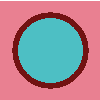

In [28]:
p = openmc.Plot()
p.filename = 'pin_cell'
p.width = (1.26, 1.26)
p.pixels = (100, 100)
p.color_by = 'material' # or 'cell'
plots = openmc.Plots([p])
plots.export_to_xml()
openmc.plot_geometry()
openmc.plot_inline(p)  

### Additional Exercises

  1. Write a Python script that uses the pin-cell model just created to produce a plot of $k_{\infty}$ as a function of the pitch-to-diameter ratio.  For simplicity, keep the fuel and cladding radii constant while adjusting the pin pitch.
  
  2. Plot `k_generations` from `statepoint.100.h5` as a function of generation.  Also plot the running average value of `k_generations` as a function of generation.  Does the final value match `k_combined`?

## Moving On: An Assembly of Fuel Pins

Let us produce a $4 \times 4$ assembly that uses the same basic fuel pin and looks like the following:


![Fuel Assembly](img/fuel_assembly.png)

Then, we'll attempt two things: 
  1. Compute the pin power distribution
  2. Compute two-group cross sections for this assembly

The materials are the *same* as for the pin cell, so the same `materials.xml` can be used.

Some of the geometry *does* change.  In summary, these are needed:
  - surfaces and cell to contain the entire $4 \times 4$ lattice
  - surfaces, cells, and universes to define each unique lattice element (i.e., fuel pin or empty coolant channel)
  - a $4\times 4$ lattice filled with these two universes

First, define the surfaces.  Note that the `left`, `right`, `bottom`, and `top` surfaces will enclose the $4 \times 4$ lattice (centered at $(x, y) = (0, 0)$) with *reflective* conditions.

In [ ]:
pitch = 1.26
left   = openmc.XPlane(x0=-pitch*2, boundary_type='reflective')
right  = openmc.XPlane(x0=pitch*2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch*2, boundary_type='reflective')
top    = openmc.YPlane(y0=pitch*2, boundary_type='reflective')
fuel_outer = openmc.ZCylinder(R=0.41)
clad_outer = openmc.ZCylinder(R=0.48)

Now, define those cells needed for the fuel pin.  Note, the `coolant` cell is *infinite* in extent, but that's okay: the lattice will impose boundaries!

In [ ]:
fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = -fuel_outer
    
cladding = openmc.Cell(2, 'cladding')
cladding.fill = zirconium #
cladding.region = +fuel_outer & -clad_outer
    
coolant = openmc.Cell(3, 'coolant')
coolant.fill = h2o
coolant.region = +clad_outer

Next, define the single cell needed for the empty coolant channel.  Note, this one is *finite*, but its bounds are outside the area defined by one lattice element, so it's okay: the lattice will define the correct boundaries.

In [ ]:
coolant_channel = openmc.Cell(4, 'coolant_channel')
coolant_channel.fill = h2o
coolant_channel.region = +left & -right & +bottom & -top # *first* use of these surfaces

Define the fuel and coolant universes:

In [ ]:
univ_f = openmc.Universe(cells=[fuel, cladding, coolant], universe_id=1)  
univ_c = openmc.Universe(cells=[coolant_channel], universe_id=2)    

### Defining Lattices of Repeated Units

Next, define the $4\times 4$ lattice:

In [ ]:
lattice2d = openmc.RectLattice(lattice_id=5)
lattice2d.lower_left = [-2*pitch, -2*pitch]
lattice2d.pitch = [pitch, pitch]
lattice2d.universes = [[univ_f, univ_f, univ_f, univ_f],
                       [univ_f, univ_c, univ_f, univ_f],
                       [univ_f, univ_f, univ_f, univ_f],
                       [univ_f, univ_f, univ_f, univ_f]]

Finally, create one cell to hold the lattice, set that as the cell for the root universe, and export the resulting geometry to XML:

In [ ]:
lattice_cell = openmc.Cell(cell_id=999)
lattice_cell.region = +left & -right & +bottom & -top # second use of these surfaces
lattice_cell.fill = lattice2d
root = openmc.Universe(universe_id=0, name='root universe')
root.add_cells([lattice_cell])
geom = openmc.Geometry(root)
geom.export_to_xml()

It's always wise to check the geometry by visual inspection:

In [ ]:
p = openmc.Plot()
p.filename = 'lattice_plot'
p.width = (4*pitch, 4*pitch)
p.pixels = (300, 300)
p.color_by = 'material'
plots = openmc.Plots([p])
plots.export_to_xml()
openmc.plot_geometry()
openmc.plot_inline(p)

### Defining `tallies.xml`

Although $k_{\text{eff}}$ is often important, most analysis requires determination of a quantity $X$ that can be represented as

$$
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int dE}_{\text{filters}}
   \underbrace{f(\mathbf{r}, \mathbf{\Omega} E)}_{\text{scores}} \psi(\mathbf{r}, \mathbf{\Omega}, E)\, .
$$

Possible **filters** include, among others, the selective integration over particular geometry cells and energy bins.  

Possible **scores** (i.e., weighting functions) include the unit weight (for computing integral fluxes), various cross sections, and neutron/energy production from fission.

Now, define a tally for the two-group flux (boundary at 0.625 eV) integrated averaged over the entire lattice volume.  First, an energy filter is needed:

In [ ]:
energy_filter = openmc.EnergyFilter([0.0, 0.625, 2.0e7])

Now, create a new tally, add the filter, and define what to score:

In [ ]:
flux_tally = openmc.Tally(tally_id=1)
flux_tally.filters = [energy_filter]
flux_tally.scores = ['flux']

Next, define a tally to compute the pin powers (as approximated by the fission density).  This is most easily accomplished using a *mesh tally*, which is a tally whose spatial integration is defined by an arbitrary Cartesian mesh.

First, define the mesh. Each mesh element aligns exactly with a lattice element:

In [ ]:
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [4, 4, 1]
mesh.lower_left = [-2*pitch, -2*pitch, -1e7]
mesh.width = [pitch, pitch, 2e7]

Now, create the mesh filter and the mesh tally:

In [ ]:
mesh_filter = openmc.MeshFilter(mesh)
mesh_tally = openmc.Tally(tally_id=2)
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['fission']

With the tallies defined, export to `tallies.xml`:

In [ ]:
tallies_file = openmc.Tallies([flux_tally, mesh_tally])
tallies_file.export_to_xml()

Update `settings.xml` to include *inactive* generations:

In [ ]:
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()

Run the simulation:

In [ ]:
!rm *.h5 # clean up any existing output
openmc.run(threads=4)

Now, view `tallies.out`:

In [ ]:
!cat tallies.out

## The End


Next steps: visit the OpenMC documentation, join the user group, and do the examples!  